# Tutorial 8b - Tolerancing, Monte Carlo

### September 2024

In this tutorial, we will continue to explore the tolerancing capabilities of Optiland and will introduce Monte Carlo analysis. Monte Carlo analysis involves simulating a large number of random variations of an optical system, which helps to understand the statistical distribution of potential performance outcomes for a system. It is particularly valuable for understanding the impact of manufacturing defects and environmental conditions.

The Monte Carlo analysis in Optiland is fundamentally similar to the sensitivity analysis, which was introduced in tutorial 8a. We require the following components to perform a Monte Carlo analysis:

1. Optic - the optical system to be analyzed.
2. Operands - the metrics which are assessed e.g., wavefront error.
3. Perturbations - the variations applied to the optic or a surface of an optic e.g., surface tilt.
4. Compensators - a parameter of the optical system that can be adjusted to counteract the effects of a perturbation.

In this example, we will perform a Monte Carlo analysis on a Cooke triplet to understand how common variations, such as surface decenter and tilt, can impact the optical performance.

In [1]:
from optiland.samples.objectives import CookeTriplet
from optiland.tolerancing.core import Tolerancing
from optiland.tolerancing.monte_carlo import MonteCarlo
from optiland.tolerancing.perturbation import DistributionSampler

1. Defining the tolerancing object

The first step is to define our optic and pass it to a Tolerancing object.

In [2]:
optic = CookeTriplet()

In [3]:
tolerancing = Tolerancing(optic)

2. Adding perturbations

The Monte Carlo anlaysis requires that we apply random perturbations to optical properties of our system. We will apply both random tilt and random decenter to every surface of the triplet, so 6 surfaces in total.

We will apply perturbations to every surface and in both the x and y axes.

Properties for tilt perturbation:

- Normal distribution, mean = 0, standard deviation = 0.01 radians

Properties for decenter perturbation:

- Normal distribution, mean = 0, standard deviation = 0.1 mm

In [4]:
# loop through all surfaces and add perturbations
for k in range(1, 7):
    # X-tilt
    sampler = DistributionSampler("normal", loc=0, scale=0.01)
    tolerancing.add_perturbation("tilt", sampler, surface_number=k, axis="x")

    # Y-tilt
    sampler = DistributionSampler("normal", loc=0, scale=0.01)
    tolerancing.add_perturbation("tilt", sampler, surface_number=k, axis="y")

    # X-decenter
    sampler = DistributionSampler("normal", loc=0, scale=0.1)
    tolerancing.add_perturbation("decenter", sampler, surface_number=k, axis="x")

    # Y-decenter
    sampler = DistributionSampler("normal", loc=0, scale=0.1)
    tolerancing.add_perturbation("decenter", sampler, surface_number=k, axis="y")

3. Adding operands


We wish to monitor the impact of perturbations on our triplet. We choose to monitor the following metrics:

- RMS spot size for (Hx, Hy) = (0, 1) field
- mean OPD difference for (Hx, Hy) = (0, 1) field
- real y-intercept on image plane for (Hx, Hy) = (0, 1) field

The syntax used here follows that used in the optimization module when variables are defined. In general, we pass the following arguments to the "add_operand" method to create a new operand:

- operand type - see optiland.optimization.operand for complete list of options.
- input_data - a dictionary containing the optic instance at a minimum, and generally other parameters related to the operand, such as wavelength.
- target (optional) - if an operand has a target, we may specify it here. This is only used when we apply compensation, or optimize the system to counteract perturbations.
- weight (optional) - if an operand is more important than others, it may be given a larger weight during compensation.

We define the 3 operands as follows:

In [5]:
input_data = {
    "optic": optic,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 1,
    "wavelength": 0.55,
    "num_rays": 5,
}
tolerancing.add_operand("rms_spot_size", input_data, target=0)

input_data = {"optic": optic, "Hx": 0, "Hy": 1, "wavelength": 0.55, "num_rays": 5}
tolerancing.add_operand("OPD_difference", input_data)

input_data = {
    "optic": optic,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 1,
    "Px": 0,
    "Py": 0,
    "wavelength": 0.55,
}
tolerancing.add_operand("real_y_intercept", input_data)

4. Run Monte Carlo analysis


We are now ready to run our Monte Carlo analysis. We first define our Monte Carlo analysis:

In [6]:
monte_carlo = MonteCarlo(tolerancing)

We can then run our Monte Carlo analysis. We choose to run 1000 iterations.

In [7]:
monte_carlo.run(num_iterations=1000)

5. View and analyze results


There are several ways to view the output data of a Monte Carlo analysis:

- Plot the distributions of the performance metrics
- Plot the cumulative distribution function (CDF) of the metrics
- Plot a heatmap showing the correlations between the perturbations and the metrics

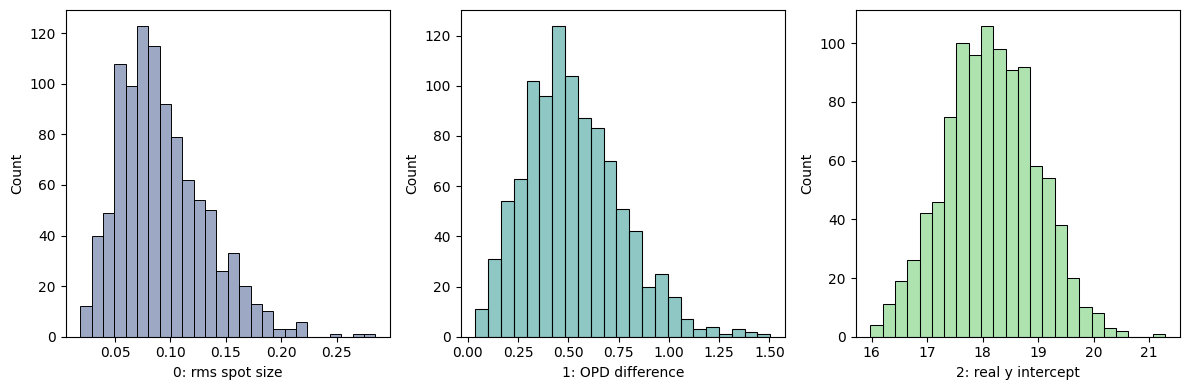

In [8]:
monte_carlo.view_histogram(kde=False)

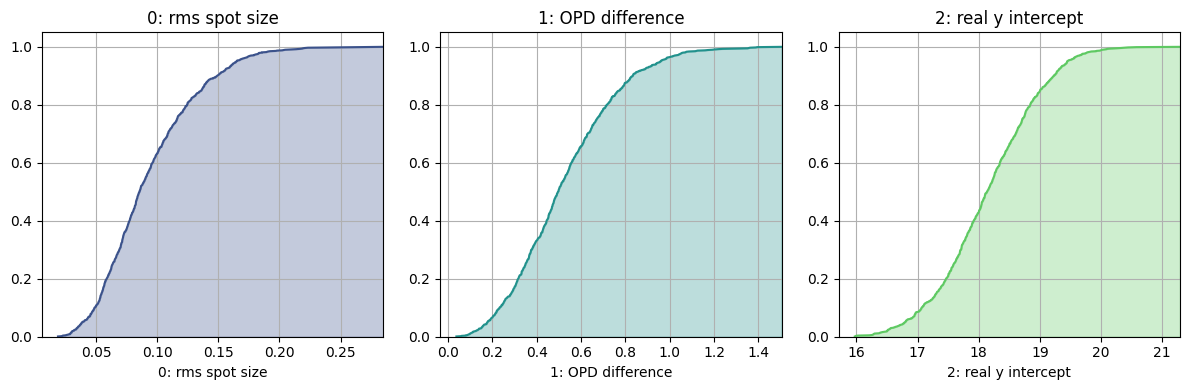

In [9]:
monte_carlo.view_cdf()

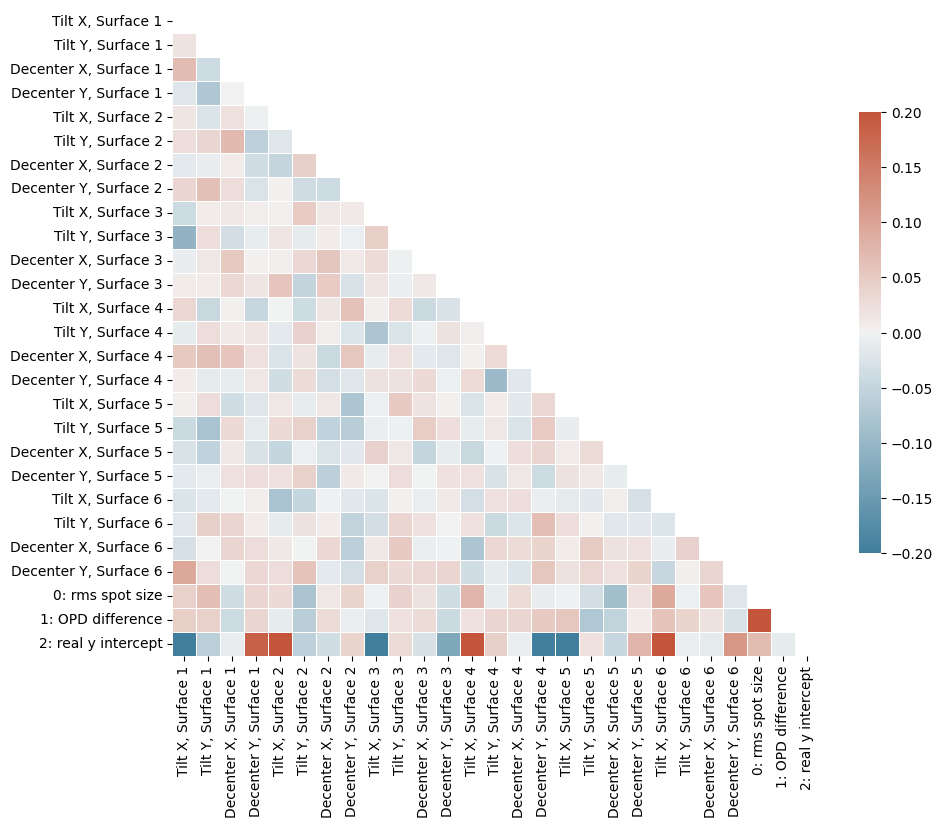

In [10]:
monte_carlo.view_heatmap(vmin=-0.2, vmax=0.2, figsize=(10, 10))

The heatmap gives an indication of the correlation between the metrics and the various pertrurbations applied. The strongest correlations exist between the real y-intercept and several of the surface tilts and decenters.

As with the sensitivity analysis, we can also retrieve the Monte Carlo results for further analysis:

In [11]:
df = monte_carlo.get_results()

In [12]:
df.head()

,"Tilt X, Surface 1","Tilt Y, Surface 1","Decenter X, Surface 1","Decenter Y, Surface 1","Tilt X, Surface 2","Tilt Y, Surface 2","Decenter X, Surface 2","Decenter Y, Surface 2","Tilt X, Surface 3","Tilt Y, Surface 3",...,"Tilt Y, Surface 5","Decenter X, Surface 5","Decenter Y, Surface 5","Tilt X, Surface 6","Tilt Y, Surface 6","Decenter X, Surface 6","Decenter Y, Surface 6",0: rms spot size,1: OPD difference,2: real y intercept
0,-0.006221,-0.008661,-0.061028,-0.025816,0.016382,-0.007767,0.123581,0.138610,0.002398,0.002283,...,0.000548,0.237340,0.033150,-0.001259,0.011874,0.122432,-0.079730,0.083058,0.152733,19.558908
1,-0.001218,-0.000293,-0.024775,-0.035325,-0.001651,-0.014804,-0.002968,0.039857,-0.008041,-0.004399,...,0.010716,-0.056133,0.024629,-0.009219,-0.016362,-0.041900,-0.185342,0.069057,0.503264,17.628797
2,0.000197,-0.007129,0.049039,0.028964,0.001362,-0.004770,-0.129937,-0.172918,-0.005845,0.004061,...,-0.002730,-0.021001,0.089267,0.009255,-0.025322,0.229231,-0.112551,0.156009,0.591829,18.787886
3,0.004874,0.000841,0.015796,0.016955,-0.009637,0.003914,-0.044681,-0.041809,0.008580,-0.003123,...,-0.003756,0.208429,-0.057769,0.004500,-0.011888,0.004488,-0.105027,0.060417,0.480440,17.122025
4,0.022222,0.008179,-0.019002,-0.009676,-0.001012,-0.010193,0.103021,-0.050787,0.018299,0.007881,...,-0.009875,-0.133196,-0.038400,-0.004322,-0.010546,0.076583,0.195792,0.091870,0.835800,16.705053


Conclusions

- This tutorial demonstrated Monte Carlo analyses in Optiland.
- Monte Carlo analysis is a statistical technique to explore possible system performance variations due to manufacturing tolerances or environmental conditions.
- Several plotting functions are available via the Monte Carlo analysis object, including plotting of distributions, CDFs, and heatmaps.